# czitle - Tutorial

In this notebook one can see how to use the **cztile** module to simplify tilewise processing of arrays.

## Remarks

* **cztile** is not dedicated to a specila image file format but can be used for any array.

## Disclaimer

This notebook is free to use for everybody. Carl Zeiss Microscopy GmbH's ZEN software undertakes no warranty concerning the use of those scripts, image analysis settings and ZEN experiments. Use them on your own risk.

Additionally Carl Zeiss Microscopy GmbH's ZEN software allows connection and usage to the third party software packages.
Therefore Carl Zeiss Microscopy GmbH undertakes no warranty concerning those software packages, makes no representation that they will work on your system and/or hardware and will not be liable for any damages caused by the use of this extension. **By using any of those examples you agree to this disclaimer.**

Version: 2022.03.22

Copyright (c) 2022 Carl Zeiss AG, Germany. All Rights Reserved.

In [10]:
# general imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import List, NamedTuple
from skimage.filters import gaussian
from tqdm import tqdm
import random

# import the ZEISS packages pylibCZIrw and cztile
from pylibCZIrw import czi as pyczi
from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D
from cztile.tiling_strategy import Tile2D, Rectangle as czrect

# show the used python env
print("Using:", sys.executable)

Using: C:\Users\m1srh\Miniconda3\python.exe


### Open a CZI

We can open a czi using a context manager and then read the data we want.

In [11]:
# define the test image to be used
czifile = "DAPI_PGC_10x_S02sm.czi"

# get the CZI metadata 
with pyczi.open_czi(czifile) as czidoc:
    mdata = czidoc.metadata

# get only specific metadata
dimensions = ["SizeX","SizeY", "SizeS", "SizeT", "SizeZ", "SizeC", "SizeM"]
for dim in dimensions:
    try:
        print(dim,' : ', int(mdata["ImageDocument"]["Metadata"]["Information"]["Image"][dim]))
    except KeyError as e:
        print(dim,' : ', None)

SizeX  :  1765
SizeY  :  1493
SizeS  :  1
SizeT  :  None
SizeZ  :  None
SizeC  :  2
SizeM  :  1


In [4]:
# read the CZI pixel data
with pyczi.open_czi(czifile) as czidoc:
    img2d = czidoc.read(plane={"C": 0})
    
# show the array shape
print("2D Array Shape: ", img2d.shape)

# create new array to "hold" the processed data
processed_img2d = np.empty_like(img2d)

2D Array Shape:  (1493, 1765, 1)


### Define a 2d processing function

The benefits of tiling are evident when the data needs to be broken down for processing.
Segmentation using Deep Neural Networks is a great example of a task where images must be cut to fit.
We can use **czitile** to break down the image into tiles with some overlap.

We can illustrate this with a simpler 2D processing function first.

In [5]:
# define a generic 2D processing function - could by a DL segmentation as well
def process2d(image2d: np.ndarray, **kwargs: int) -> np.ndarray:

    # insert or modify the desired processing function here
    image2d = gaussian(image2d, sigma=kwargs["sigma"],
                       preserve_range=True,
                       mode='nearest').astype(image2d.dtype)

    return image2d

In [6]:
# create the "tiler"
tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(total_tile_width=1400,
                                                  total_tile_height=1000,
                                                  min_border_width=128)

# create the tiles
tiles = tiler.tile_rectangle(czrect(x=0, y=0, w=img2d.shape[1], h=img2d.shape[0]))

# show the tile locations
for tile in tiles:
    print(tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h)

0 0 1400 1000
0 493 1400 1000
365 0 1400 1000
365 493 1400 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41it/s]


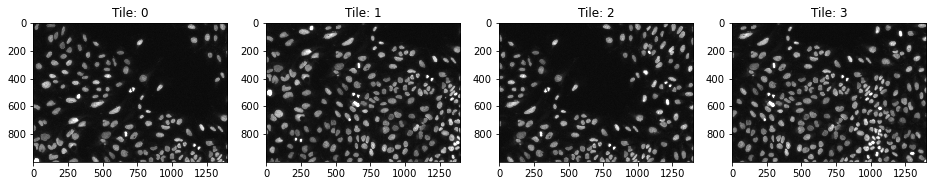

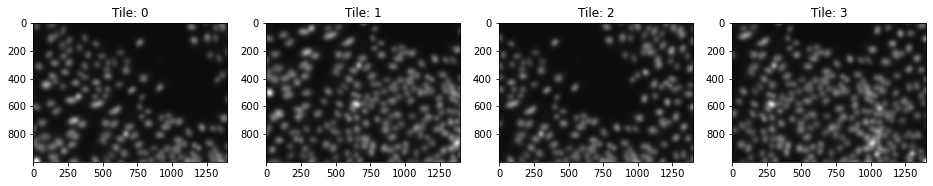

In [7]:
fig1, ax1 = plt.subplots(1, 4, figsize=(16, 8))
fig2, ax2 = plt.subplots(1, 4, figsize=(16, 8))
a = 0

# iterate over all tiles and apply the processing
for tile in tqdm(tiles):
    
    #print(tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h)

    # get a single frame based on the tile coordinates and size
    tile2d = img2d[tile.roi.y:tile.roi.y + tile.roi.h, tile.roi.x:tile.roi.x + tile.roi.w]

    # do some processing here
    tile2d_processed = process2d(tile2d, sigma=15)
    
    ax1[a].imshow(tile2d, interpolation="nearest", cmap="gray",vmin=100, vmax=4000)
    ax1[a].set_title("Tile: " + str(a))
    ax2[a].imshow(tile2d_processed, interpolation="nearest", cmap="gray",vmin=100, vmax=4000)
    ax2[a].set_title("Tile: " + str(a))

    # place frame inside the new image
    processed_img2d[tile.roi.y:tile.roi.y + tile.roi.h, tile.roi.x:tile.roi.x + tile.roi.w] = tile2d_processed
    
    a += 1

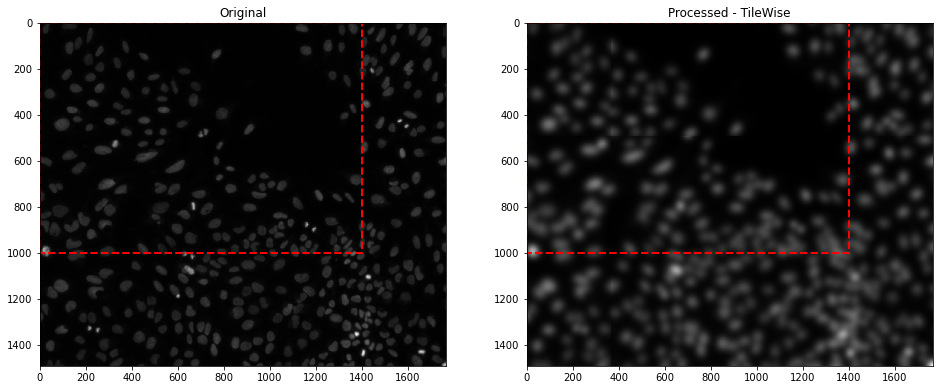

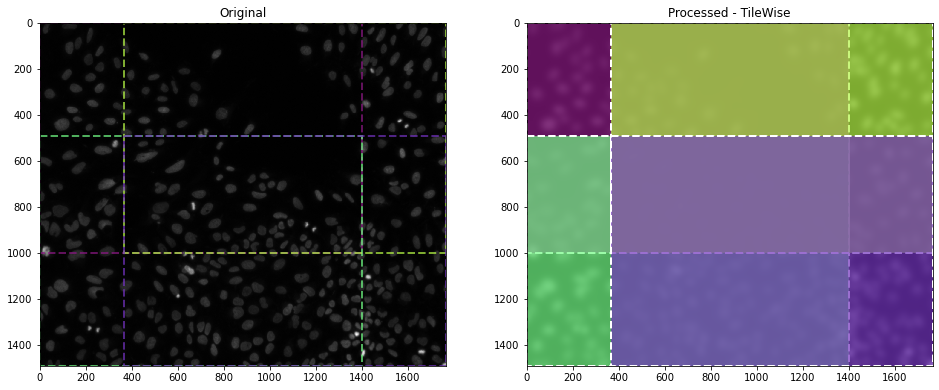

In [8]:
# show the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img2d, interpolation="nearest", cmap="gray")
ax1.set_title('Original')
ax2.imshow(processed_img2d, interpolation="nearest", cmap="gray")
ax2.set_title('Processed - TileWise')

# define the tile to be shown
tn = 0
 
#add rectangle to plot
ax1.add_patch(Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=2,
              ls="--"))

ax2.add_patch(Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=2,
              ls="--"))

# show the results
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8))
ax3.imshow(img2d, interpolation="nearest", cmap="gray")
ax3.set_title('Original')
ax4.imshow(processed_img2d, interpolation="nearest", cmap="gray")
ax4.set_title('Processed - TileWise')


edge_color_opacity = 1.0
face_color_opacity = 0.7

# visualize a single tile
for tile in tiles:
    
    r = random.random()
    b = random.random()
    g = random.random()
    edgecolor = (r, g, b, face_color_opacity)
    facecolor = (r, g, b, face_color_opacity)
    
    # add rectangle to plot
    ax3.add_patch(Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=edgecolor,
                  fill=False,
                  lw=2,
                  ls="--"))

    ax4.add_patch(Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=(1, 1, 1, edge_color_opacity),
                  facecolor=facecolor,          
                  fill=True,
                  lw=2,
                  ls="--"))